# Roman Observatory Sample Pointing Calculations

This notebook is intended to demonstrate calculation of Roman observatory pointing angles.
Specifically, we will recreate a sample calculation equivalent to the observing scenario in OS 11

In [1]:
from roman_pointing.roman_pointing import calcRomanAngles, getL2Positions, getSunPositions
import astropy.units as u
from astropy.time import Time
from astroquery.simbad import Simbad
from astroquery.jplhorizons import Horizons
from astropy.coordinates import (
    SkyCoord,
    Distance,
    get_body_barycentric,
    BarycentricMeanEcliptic,
)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Query Star Data

First, query information about the target (47 UMa) and a reference star (Zeta Pup)

In [2]:
# generate Simbad object and specify returns
simbad = Simbad()
simbad.add_votable_fields("pmra", "pmdec", "plx_value", "rvz_radvel")

In [3]:
# query for 47 Uma and then build skycoord object
res = simbad.query_object("47 Uma")
target = SkyCoord(
    res["ra"].value.data[0],
    res["dec"].value.data[0],
    unit=(res["ra"].unit, res["dec"].unit),
    frame="icrs",
    distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
    pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
    pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
    radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
    equinox="J2000",
    obstime="J2000",
).transform_to(BarycentricMeanEcliptic)

# query for Zeta Pup and build second skycoord object
res = simbad.query_object("zet pup")
ref = SkyCoord(
    res["ra"].value.data[0],
    res["dec"].value.data[0],
    unit=(res["ra"].unit, res["dec"].unit),
    frame="icrs",
    distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
    pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
    pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
    radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
    equinox="J2000",
    obstime="J2000",
).transform_to(BarycentricMeanEcliptic)

## Compute Discrete Pointings

Now, we can compute the pointing angles for each.  For these calculations, we are placing the observatory at L2.

In [4]:
t_str = ["2026-05-21T00:00:00.0"]
t0 = Time(t_str, format="isot", scale="utc")
ts_targ = t0 + [171.25] * u.h
ts_ref = t0 + [170.75] * u.h

sun_ang_targ, yaw_targ, pitch_targ, B_C_I_targ = calcRomanAngles(
    target, ts_targ, getL2Positions(ts_targ)
)

sun_ang_ref, yaw_ref, pitch_ref, B_C_I_targ = calcRomanAngles(
    ref, ts_ref, getL2Positions(ts_ref)
)

In [5]:
print(f"Initial target pitch: {pitch_targ[0].to(u.deg)}")
print(f"Initial reference pitch: {pitch_ref[0].to(u.deg)}")
print(fr"Initial $\Delta$pitch: {(pitch_targ[0] - pitch_ref[0]).to(u.deg)}")

Initial target pitch: -6.332905475608329 deg
Initial reference pitch: -9.283439536613182 deg
Initial $\Delta$pitch: 2.950534061004853 deg


In [6]:
# Target look vector (this is the unit vector from observatory to target in ecliptic frame components):
np.matmul(B_C_I_targ[:, :, 0].T, np.array([1,0,0],ndmin=2).T)

array([[-0.39332929],
       [ 0.3473734 ],
       [-0.85124837]])

## Compute Values Over One Year

In [7]:
# Now, let's look at the pointing values over the course of a full year
t_str = ["2027-01-01T00:00:00.0"]
t0 = Time(t_str, format="isot", scale="utc")
ts = t0 + np.arange(365)*u.d

sun_ang_targ, yaw_targ, pitch_targ, B_C_I_targ = calcRomanAngles(
    target, ts, getL2Positions(ts)
)

sun_ang_ref, yaw_ref, pitch_ref, B_C_I_targ = calcRomanAngles(
    ref, ts, getL2Positions(ts)
)

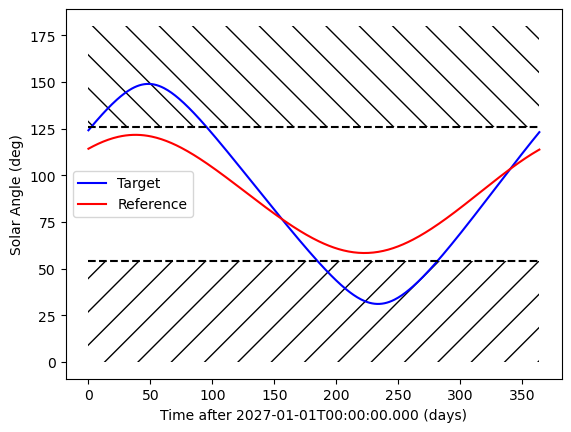

In [8]:
# plot solar angles
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(range(len(ts)), sun_ang_targ.to(u.deg),'b',label="Target")
ax1.plot(range(len(ts)), sun_ang_ref.to(u.deg),'r',label="Reference")
ax1.set_xlabel(f"Time after {ts[0].value} (days)")
ax1.set_ylabel("Solar Angle (deg)")
ax1.plot([0, len(ts)-1], [54] * 2, "k--")
ax1.plot([0, len(ts)-1], [126] * 2, "k--")
ax1.fill_between(
    [0, len(ts)-1],
    [54] * 2,
    [0] * 2,
    hatch="/",
    color="none",
    edgecolor="k",
    linewidth=0,
)
ax1.fill_between(
    [0, len(ts)-1],
    [126] * 2,
    [180] * 2,
    hatch="\\",
    color="none",
    edgecolor="k",
    linewidth=0,
)
plt.legend();

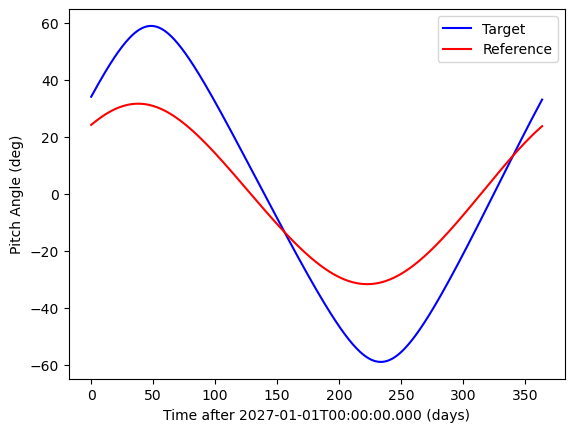

In [9]:
# plot pitch angles
fig2, ax2 = plt.subplots(1, 1)
ax2.plot(range(len(ts)), pitch_targ.to(u.deg),'b',label="Target")
ax2.plot(range(len(ts)), pitch_ref.to(u.deg),'r',label="Reference")
ax2.set_xlabel(f"Time after {ts[0].value} (days)")
ax2.set_ylabel("Pitch Angle (deg)")
plt.legend();

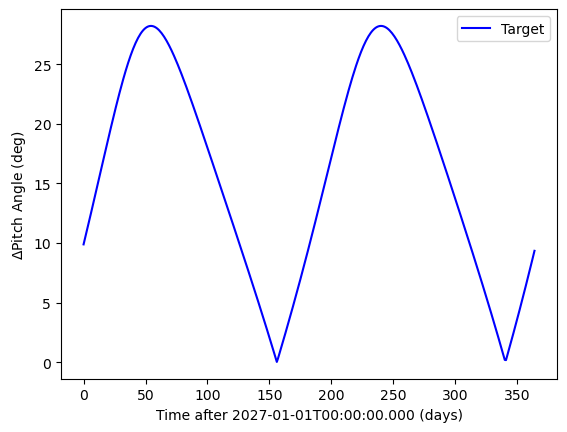

In [10]:
# plot delta pitch
fig3, ax3 = plt.subplots(1, 1)
ax3.plot(range(len(ts)), np.abs(pitch_targ - pitch_ref).to(u.deg),'b',label="Target")
ax3.set_xlabel(f"Time after {ts[0].value} (days)")
ax3.set_ylabel(r"$\Delta$Pitch Angle (deg)")
plt.legend();

## Keepout Map
We can use the solar angle we've already calculated to generate a keepout map for the target (or for multiple targets). Here's a demonstration for the target and reference star

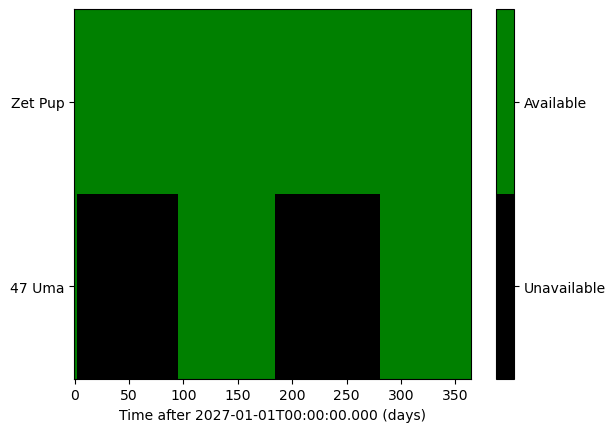

In [11]:
# generate Boolean keepout map
angs = np.vstack((sun_ang_targ.to_value(u.deg), sun_ang_ref.to_value(u.deg)))
komap = (angs > 54) & (angs < 126)

fig4, ax4 = plt.subplots(1, 1)
cmap = matplotlib.colors.ListedColormap(["black", "green"])
p = ax4.pcolor(
    range(len(ts)),
    np.arange(2),
    komap,
    cmap=cmap,
)
ax4.set_xlabel(f"Time after {ts[0].value} (days)")
ax4.set_yticks([0,1])
ax4.set_yticklabels(['47 Uma', 'Zet Pup'])
cbar = plt.colorbar(p,ticks=[0.25, 0.75], drawedges=True)
cbar.ax.set_yticklabels(["Unavailable", "Available"]);

## Using a real Roman Orbit

JPL Horizons now includes a Roman orbit (assuming a launch date of October 30, 2026). Here is an example of how to query and use this orbit data:

In [12]:
# create a Horizons object
# NB - putting in all individual epochs creates a query that is way too long, 
# so you must use the start/stop/step dictionary
dt = f"{int((ts[1] - ts[0]).to_value(u.d))}d"
obj = Horizons(id='-211', location="@0", epochs={"start":ts[0].value, "stop":ts[-1].value, "step":dt})
roman_vectors_table = obj.vectors()

In [13]:
# inspect the first few rows
roman_vectors_table[0:5]

targetname,datetime_jd,datetime_str,x,y,z,vx,vy,vz,lighttime,range,range_rate
---,d,---,AU,AU,AU,AU / d,AU / d,AU / d,d,AU,AU / d
str32,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64
Roman Space Telescope (spacecraf,2461406.5,A.D. 2027-Jan-01 00:00:00.0000,-0.1670950336802342,0.9731981502172126,0.0003480147648515523,-0.0173634624126385,-0.0030076653837039,-2.262503113929822e-05,0.005702971262672041,0.9874388644270994,-2.604103000085837e-05
Roman Space Telescope (spacecraf,2461407.5,A.D. 2027-Jan-02 00:00:00.0000,-0.1844338941227748,0.970038318629342,0.000325213620359546,-0.01731336418531085,-0.003311861007530737,-2.297314769284464e-05,0.005702839061410173,0.9874159744881742,-1.971649021290729e-05
Roman Space Telescope (spacecraf,2461408.5,A.D. 2027-Jan-03 00:00:00.0000,-0.2017199753393573,0.9665747172605432,0.0003020767729981432,-0.01725790586258292,-0.003615189447618032,-2.329635235988374e-05,0.005702743769829622,0.9873994752624627,-1.326049970705611e-05
Roman Space Telescope (spacecraf,2461409.5,A.D. 2027-Jan-04 00:00:00.0000,-0.2189479231370669,0.9628082598170806,0.0002786293932692865,-0.01719709944698528,-0.003917557637614457,-2.359412377646622e-05,0.005702686131612291,0.9873894955144948,-6.678436373903429e-06
Roman Space Telescope (spacecraf,2461410.5,A.D. 2027-Jan-05 00:00:00.0000,-0.2361123959199038,0.9587399531076667,0.0002548971846008198,-0.01713095813172323,-0.004218872463088532,-2.386591737982181e-05,0.005702666859112661,0.9873861585846253,2.420339869011468e-08


In [14]:
# extract position vectors only
roman_pos = np.vstack([roman_vectors_table[l].data.filled() for l in ["x", "y", "z"]])*u.AU

Before proceeding, let's take a look at how good our approximation of L2 (used in all the cells above) really was:

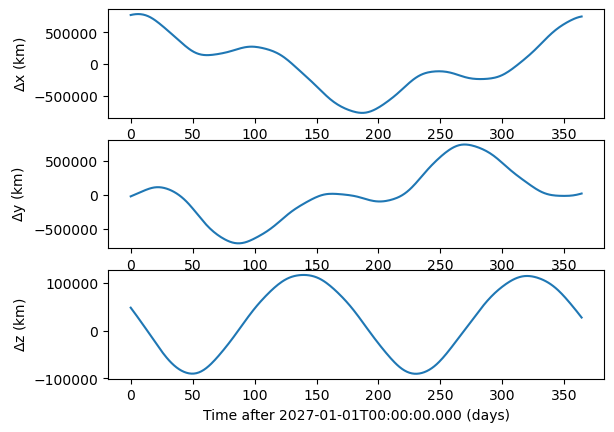

In [15]:
# compare against our L2 location approximation 
L2pos = getL2Positions(ts)
fig5, ax5 = plt.subplots(3, 1)
for j, n in enumerate(["x", "y", "z"]):
    ax5[j].plot(range(len(ts)), (roman_pos[j]- L2pos[j]).to_value(u.km))
    ax5[j].set_ylabel(f"$\\Delta${n} (km)")
ax5[j].set_xlabel(f"Time after {ts[0].value} (days)");

Not bad - every component is within ~500 Mm of our approximation of L2, which means that the approximation wasn't entirely terrible. We can now run the other calculations exactly as before, except with the 'true' orbit.

In [16]:
sun_ang_targ2, yaw_targ2, pitch_targ2, B_C_I_targ2 = calcRomanAngles(
    target, ts, roman_pos
)

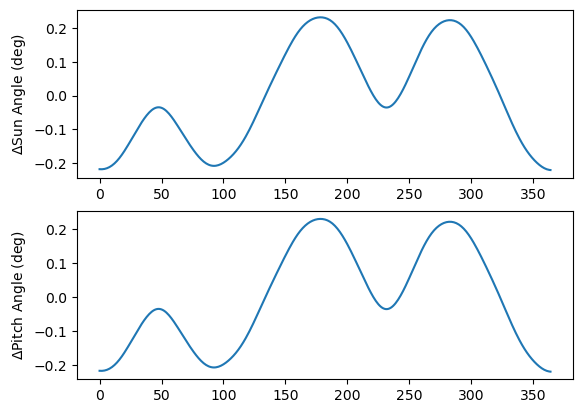

In [17]:
# compare the two calculations:
atL2 = (sun_ang_targ,  pitch_targ)
atRoman = (sun_ang_targ2, pitch_targ2)
fig6, ax6 = plt.subplots(2, 1)
for j,n in enumerate(["Sun Angle", "Pitch Angle"]):
    ax6[j].plot(range(len(ts)), (atRoman[j] - atL2[j]).to_value(u.deg))
    ax6[j].set_ylabel(f"$\\Delta${n} (deg)")
ax6[j].set_xlabel(f"Time after {ts[0].value} (days)");

NB: the $\Delta$ Pitch Angle plotted above is **not** the difference in pitch between a target and a reference, but rather the difference in the computed pitch angle between the case where we assume the telescope is approximately at L2 for all time and the case where we are using the 'true' Roman orbit queried from horizons.